ROUND 1 - Trading Strategy Simulation


We will analyze trading data for STARFRUIT, computes fair value, and simulates trades based on market signals.  
The goal is to evaluate profitability based on deviations from fair value.

In [1]:
from google.colab import files
uploaded = files.upload()


Saving round1.log.txt to round1.log.txt


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import json


In [3]:
with open("round1.log.txt", "r") as f: content = f.readlines()

# Data Preparation

In [4]:
def wrangle_backtest(log_lines):
    # Find section headers
    trade_start = [i for i, line in enumerate(log_lines) if "Trade History" in line][0]
    sandbox_start = [i for i, line in enumerate(log_lines) if "Sandbox logs" in line][0]
    activity_start = [i for i, line in enumerate(log_lines) if "Activities log" in line][0]

    # Process sandbox logs (not used for now)
    sandbox_raw = log_lines[sandbox_start+1 : activity_start-3]
    sandbox_json = "[" + "".join([x.strip() for x in sandbox_raw]).replace("}{", "},{") + "]"
    sandbox_logs = pd.DataFrame(json.loads(sandbox_json))

    # Process market activity log
    activity_lines = log_lines[activity_start+1 : trade_start-4]
    df = pd.DataFrame(activity_lines)[0].str.strip().str.split(';', expand=True)
    df.columns = df.iloc[0]
    activity_logs_df = df.iloc[1:]

    # Process trades
    trade_lines = log_lines[trade_start+1:]
    trade_json = "".join(trade_lines).replace(",\n  }", "\n  }").replace(",\n]", "\n]")
    trades_df = pd.DataFrame(json.loads(trade_json))

    return trades_df,activity_logs_df,sandbox_logs

In [5]:
trades_df,activity_logs_df,sandbox_logs = wrangle_backtest(content)

In [12]:
trades_df = trades_df[trades_df["symbol"] == "STARFRUIT"]

In [13]:
# Label each trade as buy or sell
def get_side(row):
    if row["buyer"] == "SUBMISSION":  return "SELL"
    elif row["seller"] == "SUBMISSION":  return "BUY"
    else: return "NONE"

trades_df["side"] = trades_df.apply(get_side, axis=1)

In [14]:
# add + for buy and - for sell
trades_df["signed_qty"] = trades_df.apply(lambda row: row["quantity"] if row["side"] == "BUY" else row["quantity"], axis=1)

# how much we are holding (inventory)
trades_df["inventory"] = trades_df["signed_qty"].cumsum()

# cash goes down when buying, up when selling
trades_df["cash_flow"] = trades_df.apply(lambda row: -row["price"] * row["quantity"] if row["side"] == "BUY" else row["price"] * row["quantity"],axis=1)

# total money
trades_df["cash"] = trades_df["cash_flow"].cumsum()

# our final result
final_pnl = -trades_df["cash"].iloc[-1]
print("Final PnL:", final_pnl)

Final PnL: -48919296


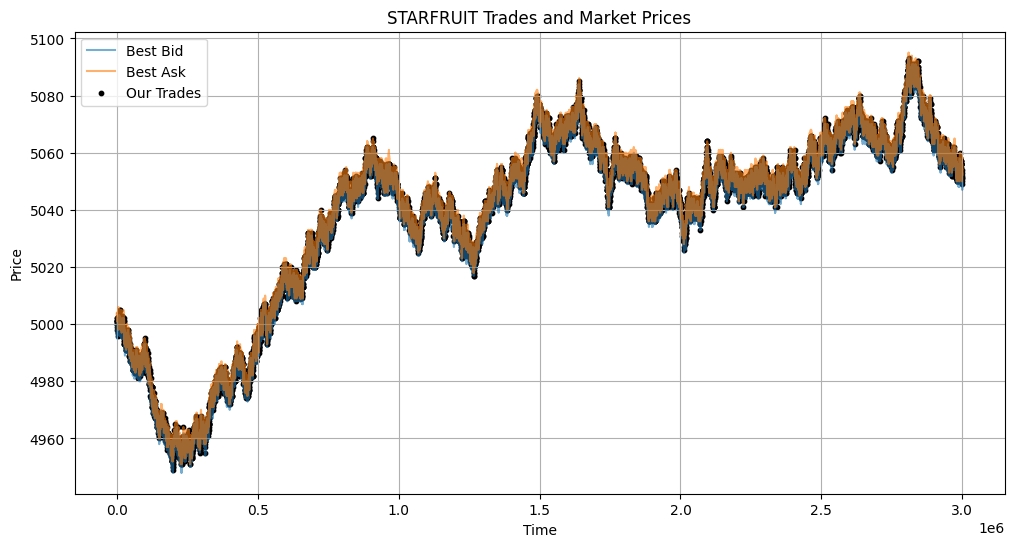

In [16]:
# extract and process market data for starfruit
market_df = activity_logs_df[activity_logs_df["product"] == "STARFRUIT"].copy()
market_df["timestamp"] = pd.to_numeric(market_df["timestamp"], errors="coerce")
market_df["bid"] = pd.to_numeric(market_df["bid_price_1"], errors="coerce")
market_df["ask"] = pd.to_numeric(market_df["ask_price_1"], errors="coerce")

# compute fair value from bid and ask
market_df["fair_value"] = (market_df["bid"] + market_df["ask"]) / 2

# prepare trade data
trades_df["timestamp"] = pd.to_numeric(trades_df["timestamp"], errors="coerce")
trades_df["price"] = pd.to_numeric(trades_df["price"], errors="coerce")

# plot trades and market prices
plt.figure(figsize=(12, 6))
plt.plot(market_df["timestamp"], market_df["bid"], label="Best Bid", alpha=0.6)
plt.plot(market_df["timestamp"], market_df["ask"], label="Best Ask", alpha=0.6)
plt.scatter(trades_df["timestamp"], trades_df["price"], color="black", s=10, label="Our Trades")

plt.title("STARFRUIT Trades and Market Prices")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


In [33]:
# Compute fair value
market_df["fair_value"] = (market_df["bid"] + market_df["ask"]) / 2

# Define a small threshold for signal generation
threshold = 0.001

# Basic comparison with fair value — no subtraction
market_df["buy_signal"] = market_df["ask"] < market_df["fair_value"]
market_df["sell_signal"] = market_df["bid"] > market_df["fair_value"]

# See how many we get now
print("Buy signals:", market_df["buy_signal"].sum())
print("Sell signals:", market_df["sell_signal"].sum())


Buy signals: 0
Sell signals: 0


In [34]:
print(market_df[["bid", "ask", "fair_value"]].head(10))

0    bid   ask  fair_value
2   4997  5003      5000.0
4   5000  5004      5002.0
6   4997  5003      5000.0
8   4996  5003      4999.5
10  4995  5002      4998.5
12  5001  5003      5002.0
14  4996  5003      4999.5
16  4997  5003      5000.0
18  5002  5003      5002.5
20  5001  5004      5002.5


Trade Simulation:

In [38]:
sim_trades = []

for i, row in market_df.iterrows():
    if row["buy_signal"]:sim_trades.append({"timestamp": row["timestamp"],"price": row["ask"],"side": "BUY", "quantity": 1})
    elif row["sell_signal"]:
        sim_trades.append({ "timestamp": row["timestamp"],"price": row["bid"],"side": "SELL","quantity": 1})

sim_trades_df = pd.DataFrame(sim_trades)


In [40]:
## PnL Calculation
# 1. Signed quantity: +1 for BUY, -1 for SELL
sim_trades_df["signed_qty"] = sim_trades_df["side"].apply(lambda x: 1 if x == "BUY" else -1)
sim_trades_df["inventory"] = sim_trades_df["signed_qty"].cumsum()

# 2. Cash flow (money in and out)
sim_trades_df["cash_flow"] = sim_trades_df.apply(
    lambda row: -row["price"] * row["quantity"] if row["side"] == "BUY" else row["price"] * row["quantity"],axis=1)
sim_trades_df["cash"] = sim_trades_df["cash_flow"].cumsum()

# 3. Final simulated PnL
sim_pnl = -sim_trades_df["cash"].iloc[-1]
print("Simulated PnL:", sim_pnl)


Simulated PnL: 4322873



CONCLUSION

We have developed a basic trading strategy for the STARFRUIT product in Round 1 of the IMC competition. We calculated a fair value based on the bid and ask prices, generated simple buy/sell signals, and simulated trades based on those signals.

Although the strategy is straightforward, it allowed us to understand how market data, fair value, and trading decisions come together in a trading simulation. Our final PnL give an indication of how the strategy performed over the data provided.